In [65]:
import os
import keras_cv
import tensorflow as tf
from tensorflow import keras



In [66]:
SPLIT_RATIO = 0.08
BATCH_SIZE = 8
LEARNING_RATE = 0.01
EPOCH = 15
GLOBAL_CLIPNORM = 10.0

In [67]:
class_ids = [
    "belcebu",
    "mazapan",
    "nina",
    "uxia"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

bounding_box_format = "rel_xywh"

path_dataset = "updated-images-and-labels"
path_weights = "last.keras"

annotations = sorted(
    [
        os.path.join(path_dataset, file_name)
        for file_name in os.listdir(path_dataset)
        if file_name.endswith(".txt")
    ]
)

images = sorted(
    [
        os.path.join(path_dataset, file_name)
        for file_name in os.listdir(path_dataset)
        if file_name.endswith(".jpg")
    ]
)

assert len(images) == len(annotations)

In [68]:
classes = []
boxes = []
for annotation_path in annotations:
	classes_for_img = []
	boxes_for_img = []
	with open(annotation_path) as annotation_file:
		for line in annotation_file.readlines():
			classes_for_img.append(int(line.split(' ')[0]))
			boxes_for_img.append([float(n) for n in line.strip().split(' ')[1:]])
	classes.append(classes_for_img)
	boxes.append(boxes_for_img)
boxes = tf.ragged.constant(boxes)
classes = tf.ragged.constant(classes)
images = tf.ragged.constant(images)

data = tf.data.Dataset.from_tensor_slices((images, classes, boxes))

num_val = int(len(images) * SPLIT_RATIO)

print(f"using {num_val} images for validation")
print(f"using {len(images) - num_val} images for training")

val_data = data.take(num_val)
train_data = data.skip(num_val)


using 70 images for validation
using 808 images for training


In [69]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

def visualize_dataset(inputs, value_range, rows, cols):
    inputs = next(iter(inputs.take(1)))
    
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
	

    keras_cv.visualization.plot_bounding_box_gallery(
        images=images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_pred=bounding_boxes,
        scale=3,
        font_scale=1.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format=bounding_box_format
)

In [70]:
train_ds = (train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(BATCH_SIZE * 4)
               .ragged_batch(BATCH_SIZE, drop_remainder=True)
.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE))

val_ds = (val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(BATCH_SIZE * 4)
               .ragged_batch(BATCH_SIZE, drop_remainder=True)
.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE))


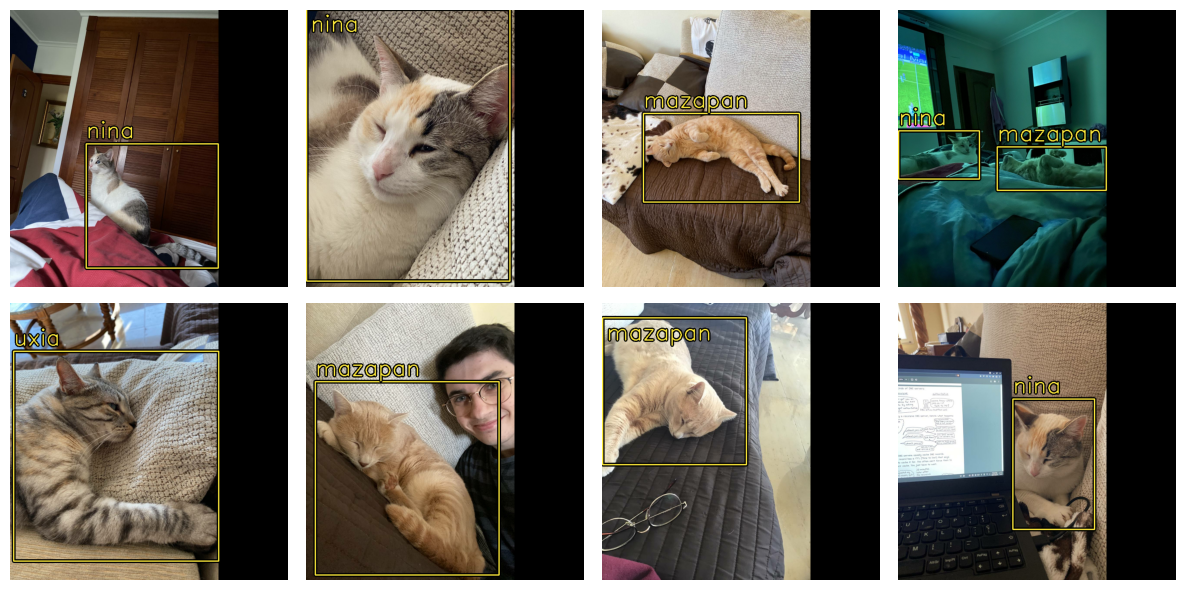

In [71]:
visualize_dataset(inputs=train_ds, value_range=(0,255), rows=2,cols=4)

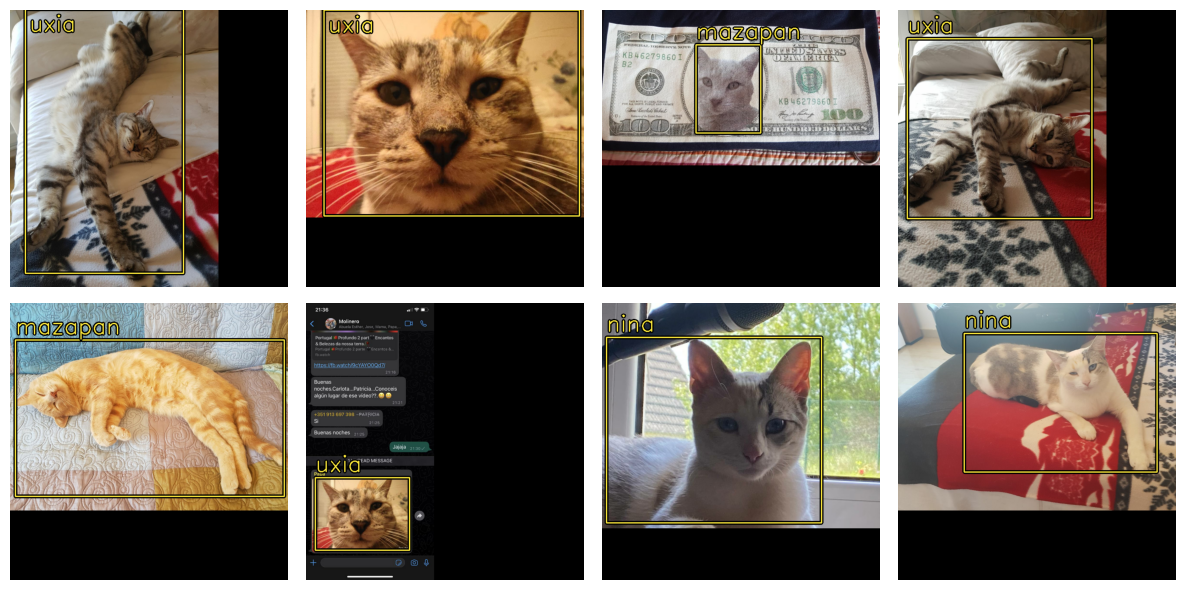

In [72]:
visualize_dataset(inputs=val_ds, value_range=(0,255), rows=2,cols=4)

In [73]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [74]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_m_backbone_coco"
    )

backbone.trainable = False
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_ids),
    bounding_box_format=bounding_box_format,
    backbone=backbone,
    fpn_depth=2
)

yolo.compile(
    classification_loss='binary_crossentropy',
    box_loss='ciou',
    optimizer=tf.optimizers.SGD(global_clipnorm=GLOBAL_CLIPNORM, learning_rate=LEARNING_RATE),
    jit_compile=False,
)
yolo.fit(train_ds, validation_data=val_ds, epochs=EPOCH)

Epoch 1/80


2023-08-08 21:41:58.886439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-08 21:41:59.324127: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: RaggedSplit/assert_equal_3/Assert/AssertGuard/branch_executed/_9


101/101 [==============================] - ETA: 0s - loss: 103.6256 - box_loss: 2.6136 - class_loss: 101.0120

2023-08-08 21:51:13.759321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-08 21:51:14.023384: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: RaggedSplit/assert_equal_3/Assert/AssertGuard/branch_executed/_9


101/101 [==============================] - 582s 6s/step - loss: 103.6256 - box_loss: 2.6136 - class_loss: 101.0120 - val_loss: 8.6267 - val_box_loss: 2.4212 - val_class_loss: 6.2055
Epoch 2/80
101/101 [==============================] - 493s 5s/step - loss: 5.4121 - box_loss: 2.2535 - class_loss: 3.1586 - val_loss: 4.4952 - val_box_loss: 2.2423 - val_class_loss: 2.2528
Epoch 3/80
101/101 [==============================] - 473s 5s/step - loss: 3.7041 - box_loss: 1.9704 - class_loss: 1.7337 - val_loss: 3.5409 - val_box_loss: 2.1039 - val_class_loss: 1.4370
Epoch 4/80
101/101 [==============================] - 451s 4s/step - loss: 3.0843 - box_loss: 1.8133 - class_loss: 1.2710 - val_loss: 3.1846 - val_box_loss: 1.9980 - val_class_loss: 1.1866
Epoch 5/80
101/101 [==============================] - 460s 5s/step - loss: 2.7177 - box_loss: 1.6640 - class_loss: 1.0536 - val_loss: 2.9667 - val_box_loss: 1.9566 - val_class_loss: 1.0100
Epoch 6/80
101/101 [==============================] - 468s 5s/

1/1 [==============================] - 2s 2s/step


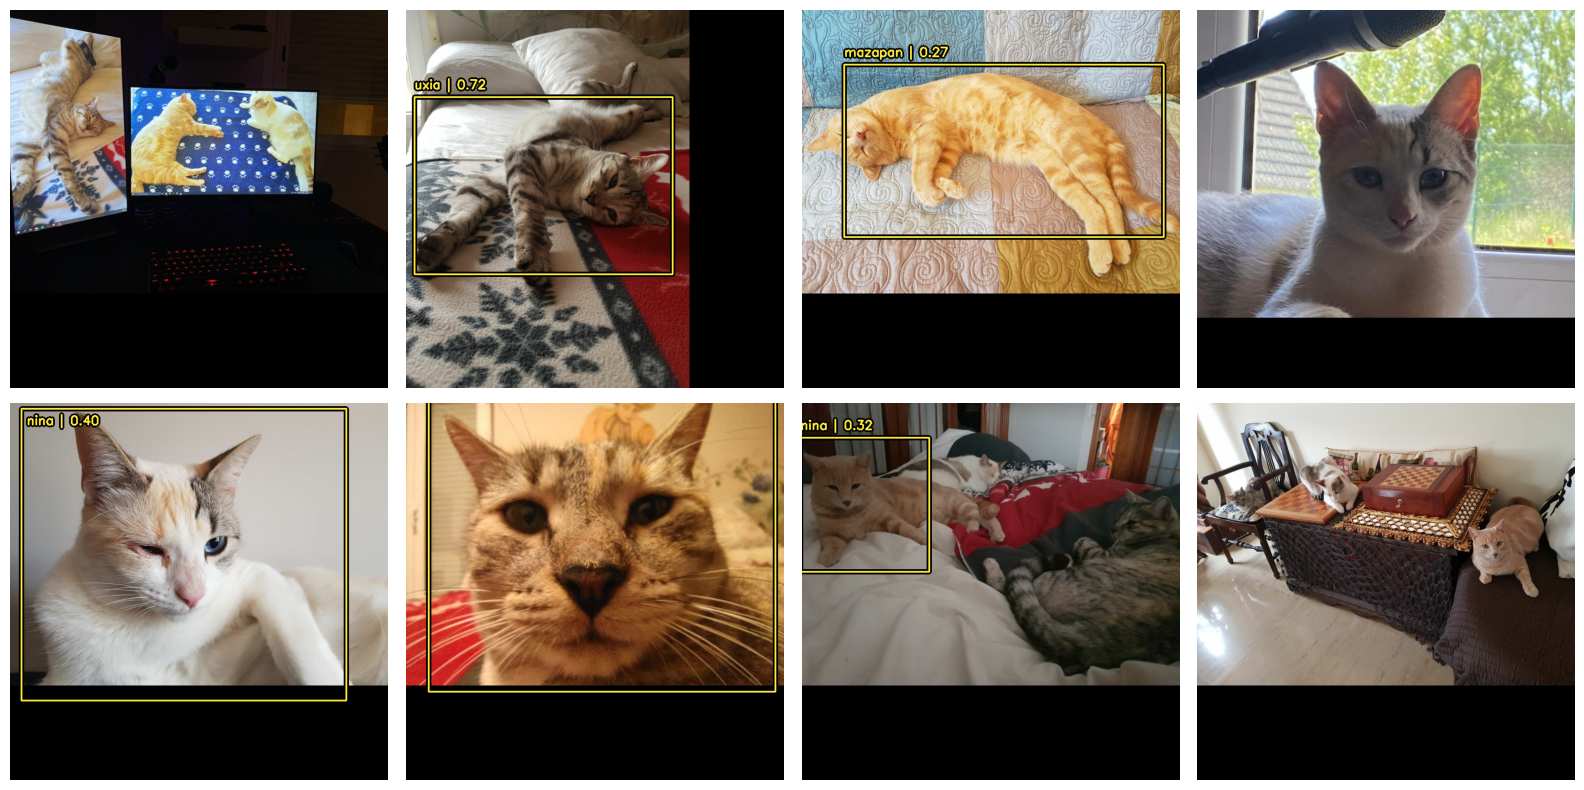

In [83]:
def visualize_detections(model, dataset):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = keras_cv.bounding_box.to_ragged(y_pred)
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds)

In [76]:
yolo.save(path_weights)